# **Classificação de imagens de carros**

## Base de dados: "Stanford Cars Dataset"

In [14]:
!gdown 1808fceK0ZZyVXyD4NPNGjMdYZG9A2lDE
!gdown 1vvHjGuyvaUv6_nn1TYdgIjQL4oQ2cJlU
!gdown 1pT1-F2xzd0T_ZlCDJkK6ypk_wcjKyWiS
!gdown 1JjDKwW3_QgXufKV4DBMQE1qApRJn3PIF

Downloading...
From (original): https://drive.google.com/uc?id=1808fceK0ZZyVXyD4NPNGjMdYZG9A2lDE
From (redirected): https://drive.google.com/uc?id=1808fceK0ZZyVXyD4NPNGjMdYZG9A2lDE&confirm=t&uuid=9cc91f2b-5cc9-477b-a5fe-018c75cf0671
To: /content/car_data.zip
100% 1.96G/1.96G [00:12<00:00, 157MB/s]
Downloading...
From: https://drive.google.com/uc?id=1vvHjGuyvaUv6_nn1TYdgIjQL4oQ2cJlU
To: /content/anno_train.csv
100% 228k/228k [00:00<00:00, 103MB/s]
Downloading...
From: https://drive.google.com/uc?id=1pT1-F2xzd0T_ZlCDJkK6ypk_wcjKyWiS
To: /content/anno_test.csv
100% 225k/225k [00:00<00:00, 19.2MB/s]
Downloading...
From: https://drive.google.com/uc?id=1JjDKwW3_QgXufKV4DBMQE1qApRJn3PIF
To: /content/names.csv
100% 5.45k/5.45k [00:00<00:00, 14.0MB/s]


In [15]:
import pandas as pd
import zipfile
import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
import numpy as np
import shutil
import warnings
import cv2 as cv
import seaborn as sns
from google.colab.patches import cv2_imshow
from skimage import io
import os
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
from tensorflow.keras.applications import ResNet50, EfficientNetB0
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications.efficientnet import decode_predictions
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet_preprocess
from tensorflow.keras.applications.efficientnet import preprocess_input as efficientnet_preprocess
import time

warnings.filterwarnings("ignore")

#Criação da pasta das imagens

In [20]:
def extract_zip(zip_path, extract_to):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(extract_to)
    return Path(extract_to)

extract_zip('car_data.zip', 'car_data')

PosixPath('car_data')

In [21]:
def move_all_contents_to_parent(parent_directory_path):
    parent_directory = Path(parent_directory_path)

    if parent_directory.exists() and parent_directory.is_dir():
        for subdirectory in parent_directory.iterdir():
            if subdirectory.is_dir():
                for item in subdirectory.iterdir():
                    shutil.move(str(item), str(parent_directory))
                if not any(subdirectory.iterdir()):
                    subdirectory.rmdir()

        print(f'Todos os elementos foram movidos das subpastas para {parent_directory}.')
    else:
        print(f'O diretório {parent_directory_path} não existe ou não é um diretório.')

move_all_contents_to_parent('car_data/car_data/train')
move_all_contents_to_parent('car_data/car_data/test')

Todos os elementos foram movidos das subpastas para car_data/car_data/train.
Todos os elementos foram movidos das subpastas para car_data/car_data/test.


#Base

In [22]:
train_df = pd.read_csv('anno_train.csv', header = None)
train_df.columns = ['filename', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']
test_df = pd.read_csv('anno_test.csv', header = None)
test_df.columns = ['filename', 'bbox_x1', 'bbox_y1', 'bbox_x2', 'bbox_y2', 'class']
train_df['class'] = train_df['class'].astype(str)
test_df['class'] = test_df['class'].astype(str)

classes_df = pd.read_csv('names.csv', header = None)

In [23]:
train_df

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,39,116,569,375,14
1,00002.jpg,36,116,868,587,3
2,00003.jpg,85,109,601,381,91
3,00004.jpg,621,393,1484,1096,134
4,00005.jpg,14,36,133,99,106
...,...,...,...,...,...,...
8139,08140.jpg,3,44,423,336,78
8140,08141.jpg,138,150,706,523,196
8141,08142.jpg,26,246,660,449,163
8142,08143.jpg,78,526,1489,908,112


In [24]:
test_df

,filename,bbox_x1,bbox_y1,bbox_x2,bbox_y2,class
0,00001.jpg,30,52,246,147,181
1,00002.jpg,100,19,576,203,103
2,00003.jpg,51,105,968,659,145
3,00004.jpg,67,84,581,407,187
4,00005.jpg,140,151,593,339,185
...,...,...,...,...,...,...
8036,08037.jpg,49,57,1169,669,63
8037,08038.jpg,23,18,640,459,16
8038,08039.jpg,33,27,602,252,17
8039,08040.jpg,33,142,521,376,38


In [25]:
classes_df

,0
0,AM General Hummer SUV 2000
1,Acura RL Sedan 2012
2,Acura TL Sedan 2012
3,Acura TL Type-S 2008
4,Acura TSX Sedan 2012
...,...
191,Volkswagen Beetle Hatchback 2012
192,Volvo C30 Hatchback 2012
193,Volvo 240 Sedan 1993
194,Volvo XC90 SUV 2007


#Visualização dos dados

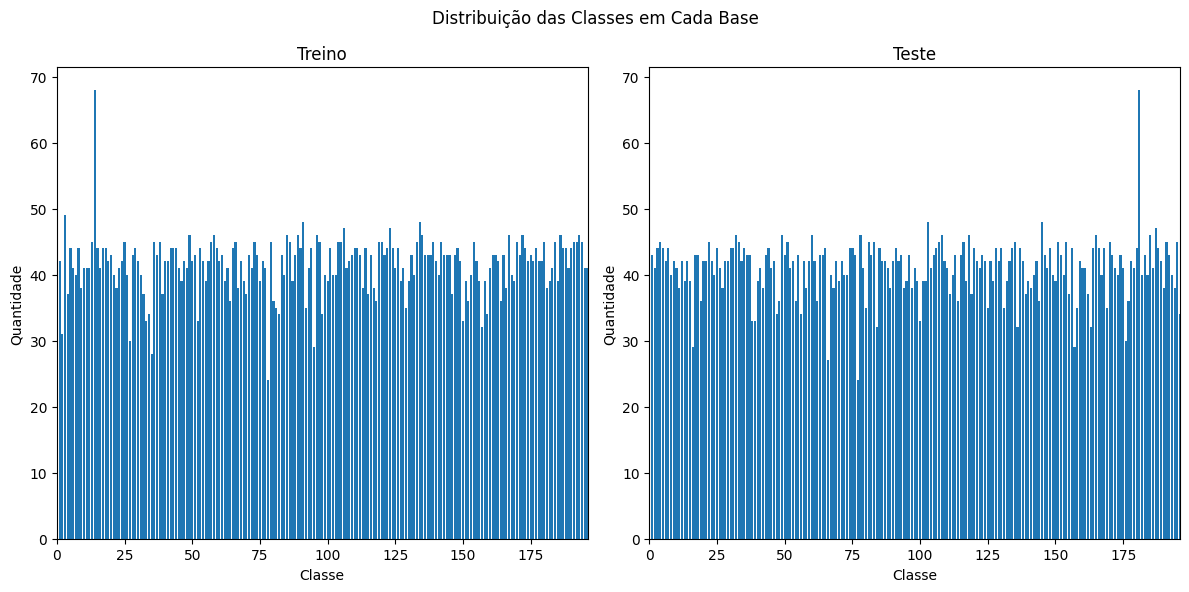

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Gráfico para a base de treino
ax1.bar(x = train_df['class'].unique().astype(int), height = train_df['class'].value_counts())
ax1.set_title('Treino')
ax1.set_xlim([0, 196])
ax1.set_xlabel('Classe')
ax1.set_ylabel('Quantidade')

# Gráfico para a base de teste
ax2.bar(x = test_df['class'].unique().astype(int), height = test_df['class'].value_counts())
ax2.set_title('Teste')
ax2.set_xlim([0, 196])
ax2.set_xlabel('Classe')
ax2.set_ylabel('Quantidade')

# Título geral
plt.suptitle('Distribuição das Classes em Cada Base')

# Exibindo o gráfico
plt.tight_layout()
plt.show()

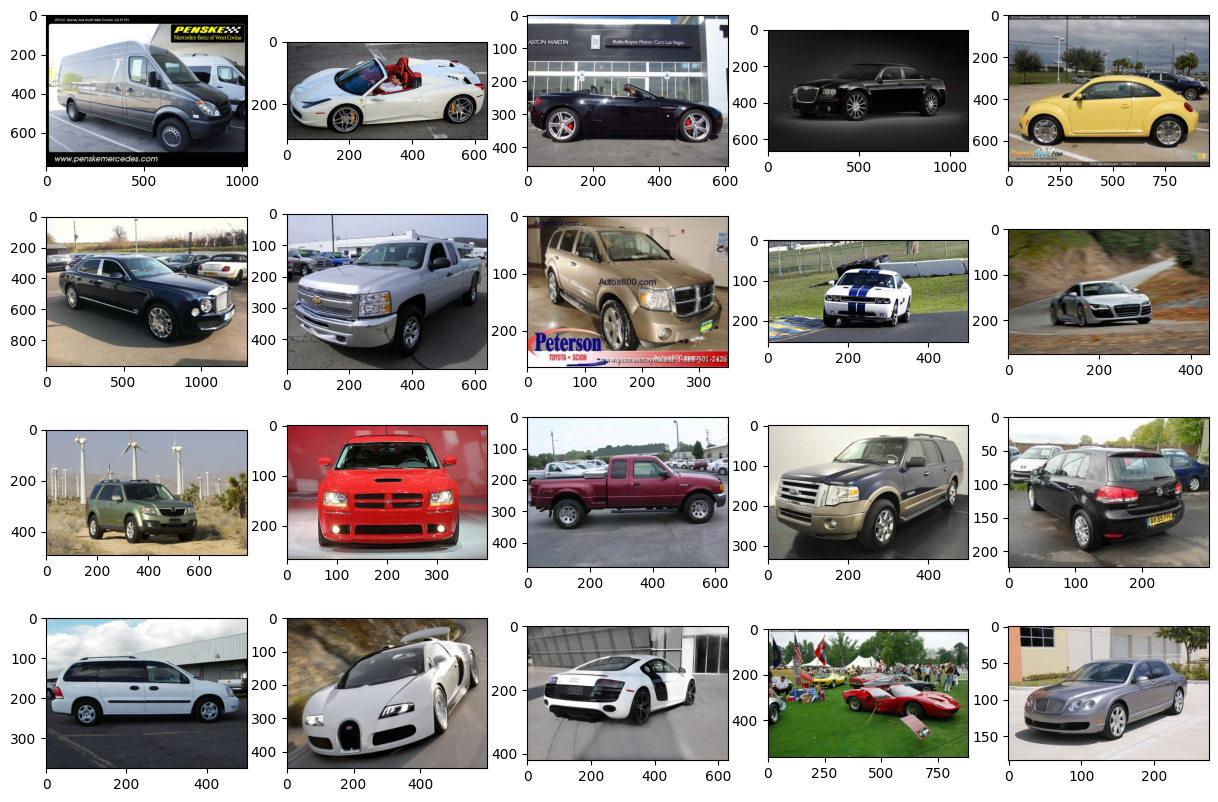

In [27]:
image_files = os.listdir('/content/car_data/car_data/train')

image_files = image_files[:20]

columns = 5
rows = 4
plt.figure(figsize=(15, 10))

for i, image_file in enumerate(image_files):
    image_path = os.path.join('/content/car_data/car_data/train', image_file)
    imagem = cv.imread(image_path)
    imagem = cv.cvtColor(imagem, cv.COLOR_BGR2RGB)

    plt.subplot(rows, columns, i + 1)
    plt.imshow(imagem)

plt.show()

Modelo número 194: Volvo 240 Sedan 1993


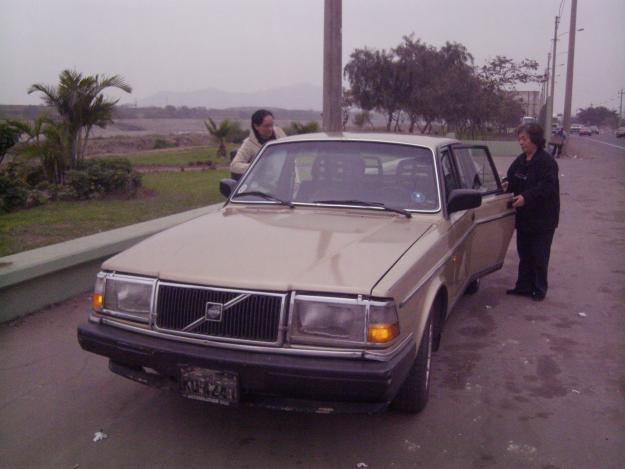

In [28]:
fn = '00369.jpg'
imag = io.imread(f'/content/car_data/car_data/test/{fn}')
imag = cv.cvtColor(imag, cv.COLOR_BGR2RGB)
classe = (test_df['class'][test_df['filename'] == fn].astype(int) - 1).values[0]

print(f'Modelo número {classe + 1}: {classes_df[0][classe]}')
cv2_imshow(imag)

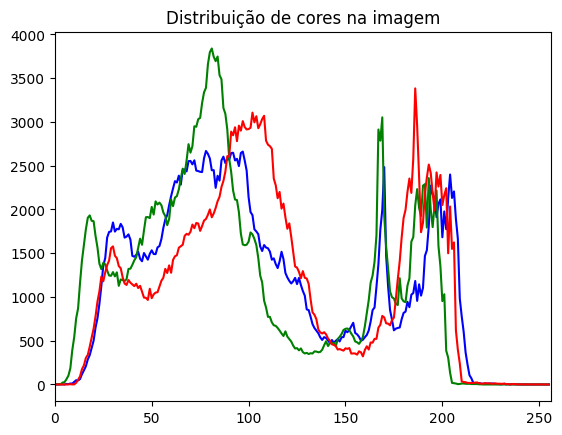

In [29]:
color = ('b','g','r')
h = {}
for i,col in enumerate(color):
    histr = cv.calcHist([imag],[i],None,[256],[0,256])
    h[col] = histr
    plt.plot(histr,color = col)
    plt.xlim([0,256])

plt.title('Distribuição de cores na imagem')
plt.show()

#Classificação

##ResNet50

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 196

train_datagen = ImageDataGenerator(preprocessing_function = resnet_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function = resnet_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/car_data/car_data/train',
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/car_data/car_data/test',
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8144 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.


In [ ]:
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(NUM_CLASSES, activation='softmax')(x)

model_res = Model(inputs=base_model.input, outputs=predictions)

for layer in base_model.layers:
    layer.trainable = False

model_res.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
start_time = time.time()

model_res.fit(train_generator, epochs=10)

end_time = time.time()

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1615s 6s/step - accuracy: 0.0540 - loss: 4.9010 - top_k_categorical_accuracy: 0.1577
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1594s 6s/step - accuracy: 0.2992 - loss: 2.8804 - top_k_categorical_accuracy: 0.6014
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1557s 6s/step - accuracy: 0.4607 - loss: 2.0849 - top_k_categorical_accuracy: 0.7777
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1595s 6s/step - accuracy: 0.6033 - loss: 1.5527 - top_k_categorical_accuracy: 0.8662
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1599s 6s/step - accuracy: 0.6905 - loss: 1.1605 - top_k_categorical_accuracy: 0.9288
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1639s 6s/step - accuracy: 0.8008 - loss: 0.8084 - top_k_categorical_accuracy: 0.9605
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1644s 6s/step - accuracy: 0.8496 - loss: 0.6287 - top_k_categorical_accuracy: 0.9797
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step - accuracy: 0.9040 - loss: 0.4466 - top_k_categorical_accuracy: 0.9923


In [ ]:
training_time = end_time - start_time
print(f"Tempo total de treinamento: {training_time:.2f} segundos")

Tempo total de treinamento: 16075.22 segundos


In [ ]:
test_loss, test_top1_acc, test_top5_acc = model_res.evaluate(test_generator)

print(f"Top-1 Accuracy no conjunto de teste: {test_top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy no conjunto de teste: {test_top5_acc * 100:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 1615s 6s/step - accuracy: 0.4538 - loss: 2.3481 - top_k_categorical_accuracy: 0.7622
Top-1 Accuracy no conjunto de teste: 46.36%
Top-5 Accuracy no conjunto de teste: 76.67%


252/252 ━━━━━━━━━━━━━━━━━━━━ 1606s 6s/step


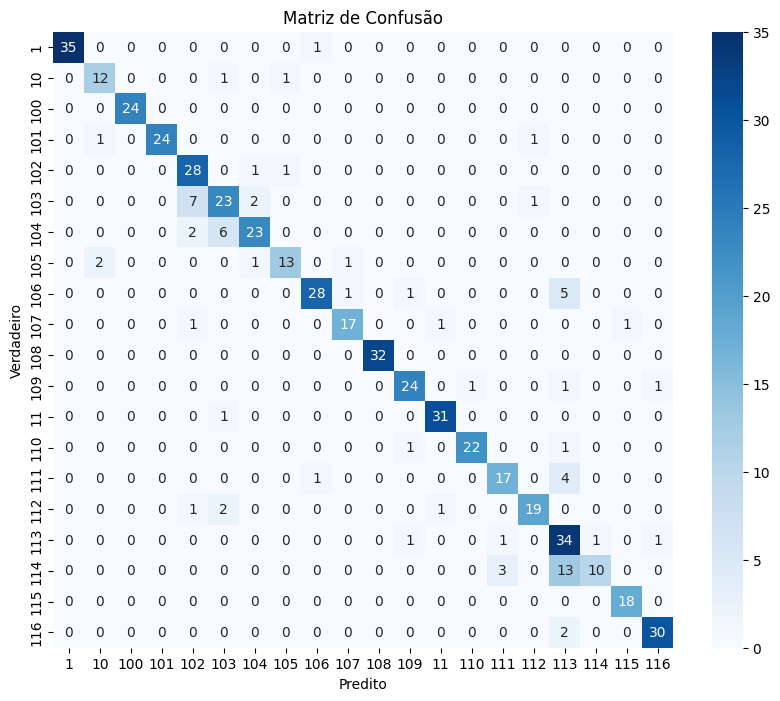

In [ ]:
predictions = model_res.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

limited_classes = 20
conf_matrix_limited = conf_matrix[:limited_classes, :limited_classes]
limited_labels = class_labels[:limited_classes]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_limited, annot=True, fmt='d', cmap='Blues', xticklabels=limited_labels, yticklabels=limited_labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

##EfficientNetB0

In [ ]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32
NUM_CLASSES = 196

train_datagen = ImageDataGenerator(preprocessing_function = efficientnet_preprocess)
test_datagen = ImageDataGenerator(preprocessing_function = efficientnet_preprocess)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    directory='/content/car_data/car_data/train',
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    directory='/content/car_data/car_data/test',
    x_col='filename',
    y_col='class',
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

Found 8144 validated image filenames belonging to 196 classes.
Found 8041 validated image filenames belonging to 196 classes.


In [ ]:
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
output = Dense(NUM_CLASSES, activation='softmax')(x)

model_eff = Model(inputs=base_model.input, outputs=output)

model_eff.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy', 'top_k_categorical_accuracy'])

In [ ]:
start_time = time.time()

model_eff.fit(train_generator, epochs=10)

end_time = time.time()

Epoch 1/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 705s 3s/step - accuracy: 0.0279 - loss: 5.0323 - top_k_categorical_accuracy: 0.1002
Epoch 2/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 740s 3s/step - accuracy: 0.1445 - loss: 3.7186 - top_k_categorical_accuracy: 0.3748
Epoch 3/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 727s 3s/step - accuracy: 0.2407 - loss: 3.0836 - top_k_categorical_accuracy: 0.5479
Epoch 4/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 671s 3s/step - accuracy: 0.3159 - loss: 2.6805 - top_k_categorical_accuracy: 0.6406
Epoch 5/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 710s 3s/step - accuracy: 0.3705 - loss: 2.4123 - top_k_categorical_accuracy: 0.6993
Epoch 6/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 750s 3s/step - accuracy: 0.4150 - loss: 2.2007 - top_k_categorical_accuracy: 0.7536
Epoch 7/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 726s 3s/step - accuracy: 0.4615 - loss: 1.9957 - top_k_categorical_accuracy: 0.7874
Epoch 8/10
255/255 ━━━━━━━━━━━━━━━━━━━━ 756s 3s/step - accuracy: 0.4962 - loss: 1.8400 - top_k_categorical_accuracy: 0.8137
Epoch 9/

In [ ]:
training_time = end_time - start_time
print(f"Tempo total de treinamento: {training_time:.2f} segundos")

Tempo total de treinamento: 7242.64 segundos


In [ ]:
test_loss, test_top1_acc, test_top5_acc = model_eff.evaluate(test_generator)

print(f"Top-1 Accuracy no conjunto de teste: {test_top1_acc * 100:.2f}%")
print(f"Top-5 Accuracy no conjunto de teste: {test_top5_acc * 100:.2f}%")

252/252 ━━━━━━━━━━━━━━━━━━━━ 697s 3s/step - accuracy: 0.5443 - loss: 1.7400 - top_k_categorical_accuracy: 0.8306
Top-1 Accuracy no conjunto de teste: 53.54%
Top-5 Accuracy no conjunto de teste: 82.46%


252/252 ━━━━━━━━━━━━━━━━━━━━ 682s 3s/step


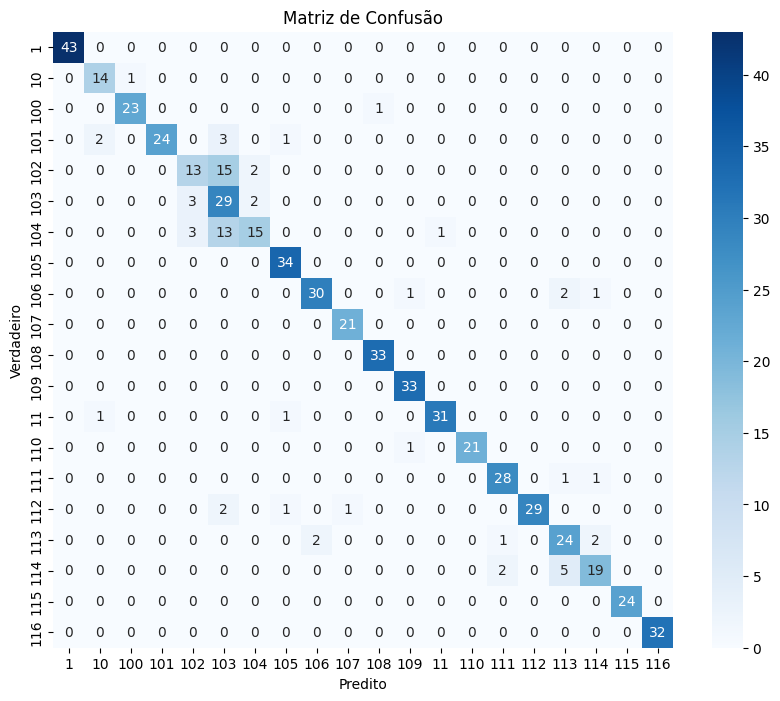

In [ ]:
predictions = model_eff.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

conf_matrix = confusion_matrix(true_classes, predicted_classes)

limited_classes = 20
conf_matrix_limited = conf_matrix[:limited_classes, :limited_classes]
limited_labels = class_labels[:limited_classes]

plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_limited, annot=True, fmt='d', cmap='Blues', xticklabels=limited_labels, yticklabels=limited_labels)
plt.xlabel('Predito')
plt.ylabel('Verdadeiro')
plt.title('Matriz de Confusão')
plt.show()

In [ ]:
classes_df_2 = pd.DataFrame(
    sorted(test_generator.class_indices.items(), key=lambda x: x[1]),
    columns=['class_value', 'model_index']
)

classes_df_2['class_value'] = classes_df_2['class_value'].astype(int)

classes_df_2 = classes_df_2.sort_values(by='class_value').reset_index(drop = True)

classes_df = pd.concat([classes_df, classes_df_2], axis = 1)

classes_df.columns = ['class_name', 'class_value', 'model_index']

classes_df

,class_name,class_value,model_index
0,AM General Hummer SUV 2000,1,0
1,Acura RL Sedan 2012,2,108
2,Acura TL Sedan 2012,3,119
3,Acura TL Type-S 2008,4,130
4,Acura TSX Sedan 2012,5,141
...,...,...,...
191,Volkswagen Beetle Hatchback 2012,192,103
192,Volvo C30 Hatchback 2012,193,104
193,Volvo 240 Sedan 1993,194,105
194,Volvo XC90 SUV 2007,195,106


In [ ]:
img = load_img(f'/content/car_data/car_data/test/{fn}', target_size = IMG_SIZE)
img_array = img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array = efficientnet_preprocess(img_array)

predictions = model_eff.predict(img_array)

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


Top-5 classes e probabilidades:
Classe: Volvo 240 Sedan 1993, Probabilidade: 0.97
Classe: Audi V8 Sedan 1994, Probabilidade: 0.02
Classe: Bentley Arnage Sedan 2009, Probabilidade: 0.00
Classe: Audi 100 Wagon 1994, Probabilidade: 0.00
Classe: Volkswagen Golf Hatchback 1991, Probabilidade: 0.00


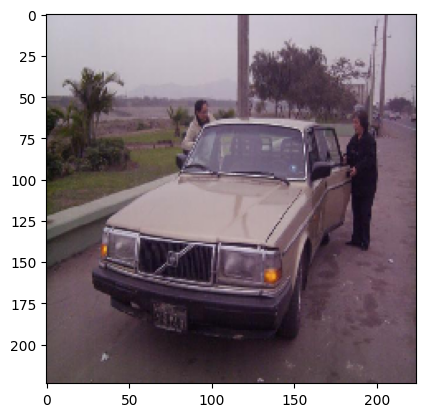

In [ ]:
top_5_indices = np.argsort(predictions[0])[-5:][::-1]

print("Top-5 classes e probabilidades:")
for idx in top_5_indices:
    class_name = classes_df.loc[classes_df['model_index'] == idx, 'class_name'].values[0]
    probability = predictions[0][idx]
    print(f"Classe: {class_name}, Probabilidade: {probability:.2f}")

plt.imshow(img)
plt.show()

In [ ]:
model_eff.save("modelo_efficientnetb0.h5")
classes_df.to_csv("classes.csv", index = False)